<a href="https://colab.research.google.com/github/hirototamura/fdi_lstm_notebooks/blob/main/torch_MultiClass_FDI_LSTM_ver_0_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Code Heritage
This is based on Simple_FaultDetection_LSTM_ver12.ipynb using TensorFlow



---


# Google drive mount

In [ ]:
# Execute to mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Install the Neptune client library

In [ ]:
# Neptune is an online visualization tool for machine learning experimet results
# Run this code block every new runtime to install Neptune client
# !pip install neptune-client neptune-tensorflow-keras tensorflow

#Import modules

In [ ]:
# System tools
import sys
import os
from pathlib import Path

# Mathematical tools
import math
import numpy as np

# Machine Learning tools
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.cuda import device_count
# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

## Machine learning extention tools
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, confusion_matrix, precision_recall_fscore_support
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import train_test_split

# Data manipulation tools
import pickle
import pandas as pd
from pandas import read_csv
from tqdm.notebook import tqdm
import time #helper libraries
from time import mktime, gmtime, strftime

# Plotting tools
import matplotlib
import matplotlib.pyplot as plt

# Setting up GPU

In [ ]:
if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')
print(f'my device is {device}')

my device is cuda


# Data modification

## Convert csv data into npy data

In [ ]:
# # Convert .csv to .npy
# # .npy is much faster to be loaded
# # data_file = '/content/drive/MyDrive/Simulation_data/230110_1s_3000s_500itrs.csv'
# # data_file = '/content/drive/MyDrive/Simulation_data/230118_1s_3000s_1000itrs.csv'
# data_file = '/content/drive/MyDrive/Simulation_data/230119_1s_3000s_1000itrs.csv'
# FEATURES = [
#             'fault id', 'time',
#             'iq1', 'iq2', 'iq3', 'iq4', 'iomega x', 'iomega y', 'iomega z',
#             'pq1', 'pq2', 'pq3', 'pq4', 'pomega x', 'pomega y', 'pomega z', # Only in data after 2023/01/10
#             'oq1', 'oq2', 'oq3', 'oq4', 'oomega x', 'oomega y', 'oomega z',
#             'act trq x', 'act trq y', 'act trq z',
#             'qua B x', 'qua B y', 'qua B z',
#             'acs mag mmt x', 'acs mag mmt y', 'acs mag mmt z',
#             'mtq mag mmt x', 'mtq mag mmt y', 'mtq mag mmt z',
#             'igrf x', 'igrf y', 'igrf z',
#             'mags x', 'mags y', 'mags z'
#             ]

# df = read_csv(data_file, header=None, index_col=None, delimiter=',', names=FEATURES)
# # with open('/content/drive/MyDrive/Simulation_data/230110_1s_3000s_500itrs.npy', 'wb') as f:
# # with open('/content/drive/MyDrive/Simulation_data/230118_1s_3000s_1000itrs.npy', 'wb') as f:
# with open('/content/drive/MyDrive/Simulation_data/230119_1s_3000s_1000itrs.npy', 'wb') as f:
#     np.save(f, df)

# del df

 ## Generate the secondary data

In [ ]:
# # Generate secondary data and append to the last
# # data_file = '/content/drive/MyDrive/Simulation_data/230110_1s_3000s_500itrs.npy'
# # data_file = '/content/drive/MyDrive/Simulation_data/230118_1s_3000s_1000itrs.npy'
# data_file = '/content/drive/MyDrive/Simulation_data/230119_1s_3000s_1000itrs.npy'
# with tf.io.gfile.GFile(data_file, 'rb') as f:
#   data = np.load(f)

# err_mmt = data[:,-12:-9] - data[:,-9:-6]
# err_mmt = err_mmt.reshape(err_mmt.shape[0],-1)

# err_mag = np.sqrt(np.power(data[:,-6],2) + np.power(data[:,-5],2) + np.power(data[:,-4],2)) \
#           - np.sqrt(np.power(data[:,-3],2) + np.power(data[:,-2],2) + np.power(data[:,-1],2))
# err_mag = err_mag.reshape(err_mag.shape[0],-1)

# EXT_FEATURES = ['fault id', 'time',
#                 'iq1', 'iq2', 'iq3', 'iq4', 'iomega x', 'iomega y', 'iomega z',
#                 'pq1', 'pq2', 'pq3', 'pq4', 'pomega x', 'pomega y', 'pomega z', # Only in data after 2023/01/10
#                 'oq1', 'oq2', 'oq3', 'oq4', 'oomega x', 'oomega y', 'oomega z',
#                 'act trq x', 'act trq y', 'act trq z',
#                 'qua B x', 'qua B y', 'qua B z',
#                 'acs mag mmt x', 'acs mag mmt y', 'acs mag mmt z',
#                 'mtq mag mmt x', 'mtq mag mmt y', 'mtq mag mmt z',
#                 'igrf x', 'igrf y', 'igrf z',
#                 'mags x', 'mags y', 'mags z',
#                 'err mmt x', 'err mmt y', 'err mmt z',
#                 'err mag']

# stacked = np.hstack((data, err_mmt, err_mag))

# df_extended = pd.DataFrame(stacked, columns=EXT_FEATURES)

# print(df_extended.head())

# # with open('/content/drive/MyDrive/Simulation_data/230110_1s_3000s_500itrs_extended.npy', 'wb') as f:
# # with open('/content/drive/MyDrive/Simulation_data/230118_1s_3000s_1000itrs_extended.npy', 'wb') as f:
# with open('/content/drive/MyDrive/Simulation_data/230119_1s_3000s_1000itrs_extended.npy', 'wb') as f:
#   np.save(f, df_extended)

# del err_mmt, err_mag, stacked, df_extended

## Repalce fault ids

In [ ]:
# # replace fault ids for making a smaller number of classes to be used

# def replace_values(df, change, target):
#     for i in range(len(change)):
#         df['fault id'].replace(change[i], target[i], inplace=True)
#     return df

# # data_file = '/content/drive/MyDrive/Simulation_data/230118_1s_3000s_1000itrs_extended.npy'
# data_file = '/content/drive/MyDrive/Simulation_data/230119_1s_3000s_1000itrs_extended.npy'
# with tf.io.gfile.GFile(data_file, 'rb') as f:
#   data = np.load(f)

# df = pd.DataFrame(data, columns=EXT_FEATURES)

# REPLACE = [23,24,25,34,35,45]
# TARGET  = [6,7,8,9,10,11]

# replace_values(df,REPLACE,TARGET)

# print('new fault id: ', sorted(df['fault id'].unique()))
# # print(sorted(set(df['fault id'])))

# # with open('/content/drive/MyDrive/Simulation_data/230118_1s_3000s_1000itrs_replaced.npy', 'wb') as f:
# with open('/content/drive/MyDrive/Simulation_data/230119_1s_3000s_1000itrs_replaced.npy', 'wb') as f:
#   np.save(f, df)

# del df

# Settings

In [ ]:
SETTING_NAME = "torch_mc_fdi_lstm_ver.0.1" # Name of the settings/run

RELOAD     = True  # Set to true when the raw files should be reloaded from disk to workspace. Set to true when DATA_SOURCE is changed
PREPROCESS = True  # Set to true when preprocessing settings are changesd. Set to false to use saved .pkl and .npy files
TRAINING   = True  # Set to true to conduct training
CROSSVAL   = False  # Set to true to use validation set during training
TEST       = True  # Set to true to conduct inference
FFT        = False  # Set to true to conduct fft on data

# Set your data path
# data_file = '/content/drive/MyDrive/Simulation_data/230110_1s_3000s_500itrs_extended.npy' # Only one fault. Used for thesis and presentation.
data_file = '/content/drive/MyDrive/Simulation_data/230118_1s_3000s_1000itrs_replaced.npy' # Contains two faults. Used for thesis and presentation.
# data_file = '/content/drive/MyDrive/Simulation_data/230119_1s_3000s_1000itrs_replaced.npy'
# Data splitting for train and test
# NUM_OF_SIMS = 500  # Decide how many of simulations to be used
NUM_OF_SIMS = 1000  # Decide how many of simulations to be used
RATIO_OF_TRAIN = 0.8 # Decide ratio of training dataset to test dataset

SIM_STEP = 3000 # 3000s / 1s = (simulation max time) / (simulation data saving intreval)
DELETE_STEP = 100 # 100 / 1s = (Kalman filter convergence time) / (simulation data saving intreval)
DS_INTERVAL = 1 # Down sampling interval

# Data source is either residual or observed
DATA_SOURCE = 'residual'
# DATA_SOURCE = 'observed'

# Specifies a list of all features in your data
EXT_FEATURES = [# fault id and simulation time
                'fault id', 'time',
                # residuals of quaternion and angular velocity
                'iq1', 'iq2', 'iq3', 'iq4', 'iomega x', 'iomega y', 'iomega z',
                # predicted values of quaternion and angular velocity
                'pq1', 'pq2', 'pq3', 'pq4', 'pomega x', 'pomega y', 'pomega z', # Only in data after 2023/01/10
                # observed avlues of quaternion and angular velocity
                'oq1', 'oq2', 'oq3', 'oq4', 'oomega x', 'oomega y', 'oomega z',
                # calculated torque inside EKF
                'act trq x', 'act trq y', 'act trq z',
                # quaternion-B-filed discripancy
                'qua B x', 'qua B y', 'qua B z',
                # commended magnetic moment
                'acs mag mmt x', 'acs mag mmt y', 'acs mag mmt z',
                # mtq's output magnetic moment
                'mtq mag mmt x', 'mtq mag mmt y', 'mtq mag mmt z',
                # magnetic field modeled as IGRF (inertial frame)
                'igrf x', 'igrf y', 'igrf z',
                # magnetic field of magnetometer (body frame)
                'mags x', 'mags y', 'mags z',
                # residuals of actuation magnetic moment
                'err mmt x', 'err mmt y', 'err mmt z',
                # residuals of the magnitude of magnetic field
                'err mag']
FEATURES = EXT_FEATURES

# Choose features to be used for training and test
INCLUDE_FEATURES = ['fault id', 'time',
                    'iq1', 'iq2', 'iq3', 'iq4',            # Residual
                    'iomega x', 'iomega y', 'iomega z',    # Residual
                    # 'pq1', 'pq2', 'pq3', 'pq4',          # Observed, Only in data after 2023/01/10
                    # 'pomega x', 'pomega y', 'pomega z',  # Observed, Only in data after 2023/01/10
                    # 'oq1', 'oq2', 'oq3', 'oq4',          # Observed
                    # 'oomega x', 'oomega y', 'oomega z',  # Observed
                    # 'act trq x', 'act trq y', 'act trq z', # Observed
                    # 'qua B x', 'qua B y', 'qua B z',     # Observed
                    # 'acs mag mmt x', 'acs mag mmt y', 'acs mag mmt z', # Observed
                    # 'mtq mag mmt x', 'mtq mag mmt y', 'mtq mag mmt z', # Observed
                    # 'igrf x', 'igrf y', 'igrf z',        # Observed
                    # 'mags x', 'mags y', 'mags z',        # Observed
                    'err mmt x', 'err mmt y', 'err mmt z', # Residual
                    'err mag'                              # Residual
                    ]
EXCLUDE_FEATURES = [ftr for ftr in FEATURES if ftr not in INCLUDE_FEATURES]


FACTOR_FOR_RESIDUAL = 100
FACTOR_FOR_OTHERS   = 1

### Settings for data preprocessing -----------------------------------------------------------

# Fault Dictionary: FAULT_DICT
# Which classes to drop. Provide keys in FAULT_DICT in list: DROP_CLASSES

# # For data_file = ".../230110_1s_3000s_500itrs_extended.npy"
# FAULT_DICT = {0: 'NOM', 1: 'Gyro Freeze', 2: 'GYR', 3: 'MAG', 4: 'RAY', 5: 'MTQ'}
# DROP_CLASSES = [1]

# For data_file = ".../230118_1s_3000s_1000itrs_replaced.npy"
FAULT_DICT = {0: 'NOM', 2: 'GYR', 3: 'MAG', 4: 'RAY', 5: 'MTQ',
              6: 'GYR+MAG', 7: 'GYR+RAY', 8: 'GYR+MTQ', 9: 'MAG+RAY', 10: 'MAG+MTQ', 11: 'RAY+MTQ'}
DROP_CLASSES = [6,7,8,9,10,11] # One fault
# DROP_CLASSES = [] # Two faults

INCLUDE_CLASSES = [cls for cls in FAULT_DICT.keys() if cls not in DROP_CLASSES]

# Number of faults/classes
NUM_CLASSES = max(FAULT_DICT.keys()) + 1
# NUM_CLASSES = 7
# NUM_CLASSES = 6


### Settings for neural net model, training, and test -----------------------------------------------------------
# Number of timesteps in the sequence
SEQ_LEN = 200
# SEQ_LEN = 20

# Number of timesteps to be shifted for the next sequence
SEQ_SHIFT = 2

# Number of units in the LSTM
# Each element is for one layer of LSTM
# It is recommended to set a value slightly bigger than the number of classification classes
# NUM_UNITS = [500, 500]
# NUM_UNITS = [100, 100]
NUM_UNITS = [50, 50]
# NUM_UNITS = [30, 30]
# NUM_UNITS = [10, 10]
# NUM_UNITS = [8, 8]
# NUM_UNITS = [4, 4]

DROPOUT = 0.3
L2REG = 0.01 # Default value is 0.01

# The batch size (this has to be a multiple of 8, since the TPU has 8 cores)
# The smaller the batch size, the more frequently the weigh updates.
# BATCH_SIZE = 1024
# BATCH_SIZE = 256
# BATCH_SIZE = 128
BATCH_SIZE = 64

# Number of training epochs
NUM_EPOCHS = 10
# NUM_EPOCHS = 20
# NUM_EPOCHS = 70
# NUM_EPOCHS = 100

# Learning rate
# LR = 0.0005
LR = 0.001

# Index of the first feature column
START = 2

# k-fold cross-validation
NUM_SPLITS = 3


In [ ]:
# Save settings
settings =  {'DATA_SOURCE': DATA_SOURCE,
             'NUM_OF_SIMS': NUM_OF_SIMS,
             'RATIO_OF_TRAIN': RATIO_OF_TRAIN,
             'SIM_STEP': SIM_STEP,
             'FEATURES': FEATURES,
             'INCLUDE_FEATURES': INCLUDE_FEATURES,
             'EXCLUDE_FEATURES': EXCLUDE_FEATURES,
             'FACTOR_FOR_RESIDUAL': FACTOR_FOR_RESIDUAL,
             'FACTOR_FOR_OTHERS': FACTOR_FOR_OTHERS,
             'SEQ_LEN': SEQ_LEN,
             'SEQ_SHIFT': SEQ_SHIFT,
             'NUM_CLASSES': NUM_CLASSES,
             'DROP_CLASSES': DROP_CLASSES,
             'INCLUDE_CLASSES': INCLUDE_CLASSES,
             'NUM_UNITS': NUM_UNITS,
             'DROPOUT': DROPOUT,
             'L2REG': L2REG,
             'BATCH_SIZE': BATCH_SIZE,
             'NUM_EPOCHS': NUM_EPOCHS,
             'LR': LR,
             'START': START,
             'CROSSVAL': CROSSVAL,
             'NUM_SPLITS': NUM_SPLITS}

t = strftime("%y%m%d_%H:%M:%S", gmtime(mktime(gmtime()) + 9*3600))
with open(Path('/content/drive/MyDrive/DL_setups/{}_{}_{}_settings.txt'.format(SETTING_NAME,t,DATA_SOURCE)), 'w') as f:
  for key, value in settings.items():
    f.write("{0} = {1}\n".format(key,value))

params = settings # for Neptune

# Function Definitions
Documentation of each function is generated by ChatGPT

## Down sample

In [ ]:
# Down sample
# Down sample data in according to provided sim_step and interval
def down_sample(data, sim_step=30000, interval=10):
    """
    Down-sample the input data by taking every 'interval' steps.
    - param data: input data to be down-sampled, numpy array
    - param sim_step: number of steps per simulation, int, default=30000
    - param interval: down-sampling interval, int, default=10
    - return: down-sampled data, numpy array
    """

    # print the shape of the input data
    print("data shape: ", data.shape)

    # calculate the number of steps in each simulation
    one_sim = sim_step + 1
    # calculate the number of simulations in the input data
    num_of_sim = data.shape[0] / one_sim

    # iterate through each simulation
    for i in range(int(num_of_sim)):

        # slice the data for each simulation
        each = data[i*one_sim:(i+1)*one_sim,:]
        # print(each.shape)

        # down-sampled data
        if i == 0:
            dn = each[::interval,:]
        else:
            dn = np.vstack((dn,each[::interval,:]))

    # print the shape of the down-sampled data
    print("down sampled data shape: ", dn.shape)
    # return the down-sampled data
    return dn


#### quick playground

In [ ]:
# x = np.linspace(0, 15005, num=150005)
# data = np.stack((x,x,x), axis=1)
# print(data.shape)
# sim_step = 30000
# interval = 10


# one_sim = sim_step + 1
# num_of_sim = data.shape[0] / one_sim

# for i in range(int(num_of_sim)):

#   # Each simulation data
#   each = data[i*one_sim:(i+1)*one_sim,:]
#   print(each.shape)

#   if i == 0:
#     # down-sampled data
#     dn = each[::interval,:]
#   else:
#     dn = np.vstack((dn,each[::interval,:]))

# print(dn.shape)

## Filter out data by fault id

In [ ]:
# Filter data by fault id
# Remove rows of the identified fault ids.  This can be used for checking if the fewer-class classificaiton works well
def filter_by_faultid(np_data, drop_classes):
    """
    Filter data by removing rows corresponding to specified fault ids.
    - param np_data: input data in numpy array format
    - param drop_classes: list of fault ids to be removed
    - return: filtered data in numpy array format
    """

    # convert input numpy array to pandas dataframe
    pandas_df = pd.DataFrame(np_data)

    # print the original shape of the data
    print("original shape: ", pandas_df.shape[0])
    df = pd.DataFrame(pandas_df.to_numpy())

    #FAULT_DICT = {0: 'Nominal', 1: 'Gyro Freeze', 2: 'Gyro Bias', 3: 'MagSen Bias', 4: 'Stray Ray', 5: 'MTQ Less', 6: 'Res Mag Mmt'}
    # Filter data by fault id. Set conditions so that keys corresponding to faults removed are droped from data

    for i in drop_classes:
        drop_index = df[ df[0] == i ].index
        df.drop(drop_index, inplace=True)

    # print the filtered shape of the data
    print("class-filtered shape: ", df.shape[0])

    # return the filtered data in numpy array format
    return df.values


## Cut data before Kalman filter convergence

In [ ]:
# Cut before convergence
# Cut out data that are thought to be before the Kalman filter converges in fault-injected simulation
def cut_before_convergence(data, max_step, delete_step=10):
    """
    Cut out data before the Kalman filter converges in fault-injected simulation.
    - param data: input data to be cut, numpy array
    - param max_step: maximum number of steps for each iteration of the simulation, int
    - param delete_step: number of steps to be cut before convergence, int, default=10
    - return: data after cutting out the specified steps before convergence, numpy array
    """
    itrs = int(data.shape[0] / max_step)

    arr = np.array([])

    for it in range(itrs):
        new = np.arange(it*max_step, it*max_step + delete_step)
        arr = np.concatenate((arr, new))

    arr = arr.astype(int)
    arr_list = list(arr)
    # print(arr_list)

    # create a mask to remove the specified steps before convergence
    mask = np.ones(data.shape[0], dtype=bool)
    mask[arr_list] = False
    data = data[mask,...]

    return data


## Normalize

In [ ]:
# a = np.arange(20).reshape((10,2)) + 1
# loga = np.log10(a)
# print(loga)
# mu = np.mean(loga,axis=0)
# vrs = np.var(loga-mu,axis=0)
# max = loga-mu
# max = max.max(axis=0)
# print(mu)
# print(max)

# normalized = (loga - mu) / max
# print(normalized)

In [ ]:
# Normalize
# Normalize input data using mean and variance.
# def normalize_input(data, data_source='residual'):
  # if data_source == 'residual':
  #   # # Take log for residual values because of their exponential feature
  #   # zero_index = data[:,2:9] == 0
  #   # mid_data = np.log10(data[:,2:9])
  #   # mid_data[zero_index] = mid_data.min(axis=0)

  #   # if data.shape[1] > 15:
  #   #   mid_data = data[:,2:9]
  #   # else:
  #   #   mid_data = np.hstack((data[:,2:9],data[:,16:]))
  #  mid_data = np.hstack((data[:,2:9],data[:,16:]))

  # if data_source == 'observed':
  # #   if data.shape[1] > 15:
  # #     mid_data = data[:,9:]
  # #   else:
  # #     mid_data = data[:,9:]
  #   mid_data = data[:,9:]

  # mu = np.mean(mid_data, axis=0)

  # # ## This normalization method is often used
  # # var = np.var(mid_data - mu, axis=0)
  # # # data[:,2:9] = (mid_data - mu) / var
  # # data[:,2:15] = (mid_data - mu) / var

  # ## Devide each data by the maximum among the entire rows for each column
  # ## This make sure each data is less than one
  # max = np.abs(mid_data - mu)
  # max = max.max(axis=0)

  # # if data.shape[1] > 15:
  # #   data[:,2:9] = (mid_data - mu) / max
  # #   data = data[:,0:9]
  # # else:
  # #   data[:,2:15] = (mid_data - mu) / max
  # #   data = data[:,0:15]
  # data[:,2:15] = (mid_data - mu) / max
  # data = data[:,0:15]
  # print("normalized data colmun size: ", data.shape[1])

def normalize_input(data, data_source='residual'):
    """
    Normalize the input data to prepare for appropriate training.
    :param data: input data to be normalized, numpy array
    :param data_source: type of data, default='residual'
    :return: normalized data, numpy array
    """
    # Select all columns except the first two
    mid_data = data[:,2:]

    # Compute the mean of the data
    mu = np.mean(mid_data, axis=0)
    # Compute the max of the data
    max = np.abs(mid_data - mu)
    max = max.max(axis=0)
    # Normalize the data by subtracting the mean and dividing by the max
    normalized = (mid_data - mu) / max
    # Stack the first two columns back to the normalized data
    normalized = np.hstack((data[:,:2], normalized))
    # Print the size of normalized data columns
    print("normalized data colmun size: ", normalized.shape[1])

    return normalized


## Valid Indices with shifting capability
https://www.tensorflow.org/tutorials/structured_data/time_series#1_indexes_and_offsets

In [ ]:
# Valid indices with shifting capability
# The value of Shift decides how many step shift are used to get the next index
# Create labels and indices. Index: Stating row of one sample sliced out from simulation data. Label: Dictionary in the form of {index: Fault id}
# Extract indices that are valid as samples in training data.

def valid_indices_with_shift(data, sample_len, shift):

  # An array with the size of (data length - sample length)
  indices = np.arange(0, data.shape[0] - sample_len - shift)

  # An empty dictionary to store the future classes/labels
  labels = {idx: [] for idx in indices}

  idxs_del = []
  previous = 0
  for idx in tqdm(indices):

    # Check if idx has increased to account for shift
    if idx < previous + shift:
      # Invalid index, append to deletion index
      idxs_del.append(idx)
      continue
    previous = idx

    # Check if another simulation starts in one sample. One simulation data and next simulation data should not be in the same sample
    if data[idx + sample_len][1] < data[idx][1]:
      idxs_del.append(idx)

    # Check if a sample's time duration is longer than sample_len
    elif data[idx + sample_len][1] >= data[idx][1] and np.isin(100, data[idx:idx+sample_len][1]): # 100 being the initial time because of DEL_STEP (Data cutting before Kalman filter converges)
      idxs_del.append(idx)
      # print(data[idx][1])

    # Check if fault id is the same through the sample length (assuming in the sample length fault id can change only once)
    elif data[idx + sample_len][0] != data[idx][0]:
      idxs_del.append(idx)


    else:
      # # Valid index, determine the label
      # if 'MA' not in fault_dict[data[idx][1]]: # Check if it is an MA fault
      #   # Non MA Fault, check if t_n > fault_start
      #   labels[idx] = data[idx][1] if (data[idx+sample_len][0] > data[idx][2]) else 0
      # else:
      #   # MA fault, no need to check time
      # labels[idx] = int(data[idx+sample_len][0])

      # Put fault id of the index to a label's value from data
      labels[idx] = int(data[idx][0])
      # labels[idx] = int(data[idx + int(sample_len*0.5)][0]) # label as fault a sample containing the majority of anomalous signal
      # labels[idx] = int(data[idx + int(sample_len)][0]) # label as fault a sample containig at least one anomalous signal

  # print(data[idx + sample_len][1], '<', data[idx][1])
  # print(idxs_del[2800:2900])
  # sys.exit()

  # Delete the invalid indices
  [labels.pop(e) for e in idxs_del]
  labels_old = labels

  # Create the indices from the dictionary keys
  indices = [k for k in labels.keys()]
  for idx, lab in labels.items():
    if lab != labels_old[idx]:
      raise ValueError('There is a mismatch between the labels!')

  # print('labels ', labels)
  # sys.exit()
  return labels, indices

## Regularize imbalance of dataset

In [ ]:
# Find the smallest data size among all fault ids. Match other fault ids to the smallest size
def regularize_imbalance(labels, include_classes):
    """
    Balance the number of samples in each class, by dropping extra samples for
    classes that have more than the minimum number of samples.
    - param labels: A dictionary where the keys are indices and the values are the class labels.
    - param include_classes: A list of integers that specify the classes to include in the regularization.
    - return new_labels: A dictionary where the keys are indices and the values are the class labels after regularization.
    - return new_indices: A list of indices of the new balanced dataset.
    """

    # Convert labels dict to dataframe
    pd_labels = pd.DataFrame(list(labels.values()), index=list(labels.keys()), columns=['fault'])

    # Get the number of samples for each class in include_classes
    shapes = [pd_labels[pd_labels['fault'] == i].shape[0] for i in include_classes]

    print('class: ', include_classes)
    print('class distribution before: ', shapes)

    # Find the minimum number of samples for all classes
    size = min(shapes)

    # Drop extra samples for classes that have more than the minimum number of samples
    for i in include_classes:
        one = pd_labels[pd_labels['fault'] == i]
        if one.shape[0] > size:
            drop_index = one.iloc[size:,:].index
            pd_labels.drop(drop_index, inplace=True)

    # Convert the DataFrame to a dictionary and return it along with the indices
    new_labels = pd_labels['fault'].to_dict()
    new_indices = [k for k in new_labels.keys()]


    shapes = [pd_labels[pd_labels['fault'] == i].shape[0] for i in include_classes]
    print('class: ', include_classes)
    print('class distribution after: ', shapes)

    return new_labels, new_indices


# Load simulation data

In [ ]:
# # Load simulation data into the workspace
# if RELOAD:
#   # load the dataset as panda dataframe
#   pandas_train = read_csv(train_file, header=None, index_col=None, delimiter='  ')
#   pandas_test_1  = read_csv(test_file_1, header=None, index_col=None, delimiter='  ')
#   pandas_test_2  = read_csv(test_file_2, header=None, index_col=None, delimiter='  ')

In [ ]:
if RELOAD:
  # with tf.io.gfile.GFile(data_file, 'rb') as f:
  #   data = np.load(f)
  data = np.load(data_file)
  df = pd.DataFrame(data, columns=FEATURES)

# Preprocess data

In [ ]:
if PREPROCESS:

  # Set index of simulation id and time-step
  # when the dataset contains n simulations, simulation id between 1 and n is assigned to each simulation
  # when each simulation contains m time-steps, each simulation has m rows of steps

  num_of_steps = SIM_STEP
  num_of_sims = int(df.shape[0]/(num_of_steps+1))

  simid = np.asarray([np.ones(num_of_steps+1).astype(int) * (i+1) for i in range(num_of_sims)])
  simid = simid.reshape(num_of_sims * (num_of_steps+1))

  timestep = np.asarray([np.arange(num_of_steps+1) for i in range(num_of_sims)])
  timestep = timestep.reshape(num_of_sims * (num_of_steps+1))

  index = pd.MultiIndex.from_tuples(list(zip(simid,timestep)), names=["simulation id", "time step"])

  df2 = pd.DataFrame(df.to_numpy(), index=index, columns=FEATURES)

  # group dataframe by simulation id
  grouped = df2.groupby(level="simulation id")


In [ ]:
grouped.head() if PREPROCESS else None

fault id  time       iq1       iq2       iq3  \
simulation id time step                                                 
1             0               0.0   0.0  0.000000  0.000000  0.000000   
              1               0.0   1.0  0.036664  0.000158  0.009702   
              2               0.0   2.0 -0.000185  0.000748 -0.000194   
              3               0.0   3.0  0.000329 -0.000138 -0.000796   
              4               0.0   4.0 -0.000305 -0.000119  0.000196   
...                           ...   ...       ...       ...       ...   
1000          0               0.0   0.0  0.000000  0.000000  0.000000   
              1               0.0   1.0  0.007291  0.043682  0.021920   
              2               0.0   2.0 -0.000611 -0.000325  0.000780   
              3               0.0   3.0 -0.000258  0.000177  0.000519   
              4               0.0   4.0 -0.000976  0.000804  0.001114   

                              iq4  iomega x  iomega y  iomega z           pq1  \
simulation id time step                                                         
1             0          0.000000  0.000000  0.000000  0.000000  0.000000e+00   
              1          0.999281  0.063965  0.008100  0.027656 -1.880661e-07   
              2          1.000000 -0.000547  0.000258  0.000130  6.861378e-02   
              3          1.000000 -0.000491  0.000031  0.000307  1.001969e-01   
              4          1.000000  0.000258 -0.000309 -0.000415  1.318838e-01   
...                           ...       ...       ...       ...           ...   
1000          0          0.000000  0.000000  0.000000  0.000000  0.000000e+00   
              1          0.998778  0.005427  0.096138  0.052644 -5.355031e-07   
              2          0.999999  0.000208 -0.000047 -0.000344  1.107501e-02   
              3          1.000000  0.000298  0.001032 -0.000347  1.648020e-02   
              4          0.999999  0.000361  0.000330 -0.000299  2.390497e-02   

                         ...    igrf x        igrf y    igrf z    mags x  \
simulation id time step  ...                                               
1             0          ...  0.000000  0.000000e+00  0.000000  0.000000   
              1          ... -0.000015 -5.069719e-07  0.000022 -0.000015   
              2          ... -0.000015 -4.848527e-07  0.000022 -0.000015   
              3          ... -0.000015 -4.627361e-07  0.000022 -0.000015   
              4          ... -0.000015 -4.406224e-07  0.000022 -0.000015   
...                      ...       ...           ...       ...       ...   
1000          0          ...  0.000000  0.000000e+00  0.000000  0.000000   
              1          ... -0.000015 -5.069719e-07  0.000022 -0.000017   
              2          ... -0.000015 -4.848527e-07  0.000022 -0.000019   
              3          ... -0.000015 -4.627361e-07  0.000022 -0.000020   
              4          ... -0.000015 -4.406224e-07  0.000022 -0.000022   

                               mags y    mags z  err mmt x  err mmt y  \
simulation id time step                                                 
1             0          0.000000e+00  0.000000  -0.005469  -0.009575   
              1          1.396437e-06  0.000022  -0.001848  -0.009049   
              2          3.214093e-06  0.000022  -0.006761  -0.002891   
              3          5.011298e-06  0.000021  -0.001231  -0.002055   
              4          6.778294e-06  0.000021  -0.006733  -0.004296   
...                               ...       ...        ...        ...   
1000          0          0.000000e+00  0.000000  -0.001053  -0.003709   
              1          4.932573e-07  0.000021  -0.001006  -0.009546   
              2          1.595505e-06  0.000019  -0.005663  -0.005493   
              3          2.839856e-06  0.000017  -0.002721  -0.006130   
              4          4.188979e-06  0.000015  -0.007702  -0.002644   

                         err mmt z       err mag  
simulation id time step        

In [ ]:
if PREPROCESS:

  num_of_sims      = NUM_OF_SIMS
  ratio_of_train   = RATIO_OF_TRAIN
  last_train_simid = int(num_of_sims*ratio_of_train)

  # Split dataset into train dataset and test dataset
  train = np.arange(start=1,stop=last_train_simid+1)
  df_train = pd.concat([grouped.get_group(name) for name in train])

  test = np.arange(start=last_train_simid+1,stop=num_of_sims+1)
  df_test = pd.concat([grouped.get_group(name) for name in test])

In [ ]:
df_test[df_test["fault id"]==2] if PREPROCESS else None

fault id    time       iq1       iq2       iq3  \
simulation id time step                                                   
810           32              2.0    32.0 -0.000412 -0.001100 -0.000888   
              33              2.0    33.0  0.000056  0.000473  0.000588   
              34              2.0    34.0  0.000063 -0.000098  0.000384   
              35              2.0    35.0 -0.000197 -0.001340 -0.000344   
              36              2.0    36.0 -0.000750 -0.001244 -0.000218   
...                           ...     ...       ...       ...       ...   
999           2996            2.0  2996.0 -0.001562 -0.005455  0.000181   
              2997            2.0  2997.0 -0.001627 -0.005216 -0.000060   
              2998            2.0  2998.0 -0.001202 -0.005312  0.000271   
              2999            2.0  2999.0 -0.001090 -0.005699  0.000694   
              3000            2.0  3000.0 -0.001739 -0.006256  0.000200   

                              iq4  iomega x  iomega y  iomega z       pq1  \
simulation id time step                                                     
810           32         0.999999  0.001745  0.001496  0.000732  0.072866   
              33         1.000000  0.000878  0.001411  0.000767  0.075087   
              34         1.000000  0.000772  0.000961  0.000173  0.076937   
              35         0.999999  0.001122  0.000862  0.000317  0.078934   
              36         0.999999  0.000822  0.000876  0.000442  0.081242   
...                           ...       ...       ...       ...       ...   
999           2996       0.999984  0.000809  0.001227  0.000670  0.989809   
              2997       0.999985  0.000267  0.000760  0.001462  0.989716   
              2998       0.999985  0.000936  0.000917  0.000680  0.989648   
              2999       0.999983  0.001397  0.001196  0.001516  0.989547   
              3000       0.999979  0.000780  0.000940  0.001287  0.989419   

                         ...    igrf x        igrf y    igrf z        mags x  \
simulation id time step  ...                                                   
810           32         ... -0.000017  1.768567e-07  0.000021  1.081998e-07   
              33         ... -0.000017  1.988278e-07  0.000021  7.174636e-07   
              34         ... -0.000017  2.207918e-07  0.000021  1.309094e-06   
              35         ... -0.000017  2.427486e-07  0.000021  1.881686e-06   
              36         ... -0.000017  2.646981e-07  0.000021  2.434196e-06   
...                      ...       ...           ...       ...           ...   
999           2996       ... -0.000015  5.713229e-06  0.000021 -1.606691e-05   
              2997       ... -0.000015  5.743840e-06  0.000021 -1.614327e-05   
              2998       ... -0.000016  5.774430e-06  0.000021 -1.621907e-05   
              2999       ... -0.000016  5.804998e-06  0.000021 -1.629444e-05   
              3000       ... -0.000016  5.835544e-06  0.000021 -1.636927e-05   

                           mags y    mags z  err mmt x  err mmt y  err mmt z  \
simulation id time step                                                        
810           32         0.000021  0.000017  -0.003691  -0.001151  -0.008079   
              33         0.000022  0.000016  -0.006659  -0.008593  -0.005493   
              34         0.000022  0.000016  -0.003004  -0.007445  -0.001425   
              35         0.000022  0.000016  -0.005277  -0.003872  -0.003130   
              36         0.000022  0.000016  -0.004290  -0.000653  -0.005869   
...                           ...       ...        ...        ...        ...   
999           2996      -0.000011 -0.000018  -0.008982  -0.007637  -0.004810   
              2997      -0.000011 -0.000018  -0.001980  -0.008751  -0.006693   
              2998      -0.000011 -0.000018  -0.001360  -0.008962  -0.005295   
              2999      -0.000011 -0.000018  -0.000091  -0.001834  -0.009328   
              3000      -0.000011 -0.000018  -

In [ ]:
# Preprocess data:
# - Down sample data
# - Filter out and drop classes by fault id
# - Cut data before Kalman filter converges
# - Scaling or Normalization
# - Extract only valid indices
# - Regularize class imbalance
# - Save indices, training samples, labels

if PREPROCESS:
  # # down sample
  # # input data is downsampled to the every DS_INTERVAL of steps.
  # np_df_train = down_sample(df_train.to_numpy(), sim_step=SIM_STEP, interval=DS_INTERVAL)
  # np_df_test_1 = down_sample(df_test.to_numpy(), sim_step=SIM_STEP, interval=DS_INTERVAL)
  np_df_train = df_train.to_numpy()
  np_df_test_1  = df_test.to_numpy()

  # Filter data by fault id
  np_df_train = filter_by_faultid(np_df_train, drop_classes=DROP_CLASSES)
  np_df_test_1 = filter_by_faultid(np_df_test_1, drop_classes=DROP_CLASSES)

  # Cut out data before Kalman filter converges
  np_training = cut_before_convergence(np_df_train, max_step=SIM_STEP, delete_step=DELETE_STEP)
  data_training = normalize_input(np_training, data_source=DATA_SOURCE)

  np_test_1 = cut_before_convergence(np_df_test_1, max_step=SIM_STEP, delete_step=DELETE_STEP)
  data_test_1 = normalize_input(np_test_1, data_source=DATA_SOURCE)

  with open('/content/drive/MyDrive/DL_setups/training.npy', 'wb') as f:
    np.save(f, data_training)

  with open('/content/drive/MyDrive/DL_setups/test1.npy', 'wb', True) as f:
    np.save(f, data_test_1)

  ## training
  # labels, indices = valid_indices(data_training, sample_len=SEQ_LEN, n_classes=NUM_CLASSES)
  labels, indices = valid_indices_with_shift(data_training, sample_len=SEQ_LEN, shift=SEQ_SHIFT)
  labels, indices = regularize_imbalance(labels, include_classes=INCLUDE_CLASSES)
  # Save the training indices to file
  with open('/content/drive/MyDrive/DL_setups/training_indices.npy', 'wb') as f:
    np.save(f, indices)

  with open("/content/drive/MyDrive/DL_setups/training_labels.pkl", 'wb') as f:
    pickle.dump(labels,f)

  ## test 1
  # labels, indices = valid_indices(data_test_1, sample_len=SEQ_LEN)
  labels, indices = valid_indices_with_shift(data_test_1, sample_len=SEQ_LEN, shift=SEQ_SHIFT)
  labels, indices = regularize_imbalance(labels, include_classes=INCLUDE_CLASSES)
  # Save the training indices to file
  with open('/content/drive/MyDrive/DL_setups/test1_indices.npy', 'wb') as f:
    np.save(f, indices)

  with open("/content/drive/MyDrive/DL_setups/test1_labels.pkl", 'wb') as f:
    pickle.dump(labels,f)

original shape:  2400800
class-filtered shape:  1842308
original shape:  600200
class-filtered shape:  441758
normalized data colmun size:  45
normalized data colmun size:  45


<ipython-input-203-154999d81555>:32: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  with open('/content/drive/MyDrive/DL_setups/test1.npy', 'wb', True) as f:


  0%|          | 0/1780706 [00:00<?, ?it/s]

class:  [0, 2, 3, 4, 5]
class distribution before:  [252065, 141383, 136513, 130048, 109812]
class:  [0, 2, 3, 4, 5]
class distribution after:  [109812, 109812, 109812, 109812, 109812]


  0%|          | 0/426856 [00:00<?, ?it/s]

class:  [0, 2, 3, 4, 5]
class distribution before:  [53849, 33406, 24317, 35390, 36557]
class:  [0, 2, 3, 4, 5]
class distribution after:  [24317, 24317, 24317, 24317, 24317]


In [ ]:
if PREPROCESS:
  del df, df2, grouped, df_train, df_test, \
  np_df_train, np_df_test_1, np_training, data_training, np_test_1, data_test_1, labels, indices



---


# Dataset and Model

In [ ]:
class AocsSimulationDataset(Dataset):
  def __init__(self, device, data_source, lable_file, data_file, index_file, seq_len, ftr_start, features, exclude_ftrs, num_classes, transform=None, target_transform=None):
      self.device = device
      self.data_source = data_source

      with open(label_file, 'rb') as f:
        self.labels_dict = pickle.load(f)  # better use pandas?
      self.labels = torch.tensor([x for x in self.labels_dict.values()])

      data = np.load(data_file) # better use pandas?
      print("Data shape in storage: ", data.shape)
      temp_df = pd.DataFrame(data,columns=features)
      dropped_df = temp_df.drop(exclude_ftrs, axis=1)
      self.data = torch.from_numpy(dropped_df.to_numpy()).float()
      print("Data shpae after dropping features: ", self.data.shape)

      if DATA_SOURCE == 'residual':
        data[:,2:9] = data[:,2:9]*FACTOR_FOR_RESIDUAL
        data[:,9:] = data[:,9:]*FACTOR_FOR_OTHERS

      self.sample_indices = np.load(index_file)
      self.seq_len = seq_len
      self.ftr_start = ftr_start
      self.num_features = self.data.shape[1] - 2
      self.num_classes = num_classes
      self.transform = transform
      self.target_transform = target_transform


  def __len__(self):
      return len(self.labels)

  def __getitem__(self, idx):
      index = self.sample_indices[idx]
      sample = self.data[index:index+self.seq_len, self.ftr_start:self.ftr_start+self.num_features]
      label = self.labels[idx]

      # Move sample and label to CUDA device
      sample = sample.to(self.device)
      label = label.to(self.device)

      if self.transform:
          sample = self.transform(sample)
      if self.target_transform:
          label = self.target_transform(label, self.num_classes)
      return sample, label

In [ ]:
# train_dataloader = DataLoader(training_dataset, batch_size=64, shuffle=True)

# train_features, train_labels = next(iter(train_dataloader))
# train_features.to(device)
# train_labels.to(device)

# print(f'training_dataset.data[0].device {training_dataset.data[0].device}, training_dataset.label[0].device {training_dataset.labels[0].device}')

# print(f'data.shape {train_features.device}, labels.shape {train_labels.device}')

# print(f"Feature batch shape: {train_features.size()}")
# print(f"Labels batch shape: {train_labels.size()}")
# label = train_labels[0]
# data = train_features[0].squeeze()
# print(f"Label: {label}")
# print(f'data: {data.shape}')

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, seq_len=32, n_features=10, num_units=[32,32], num_classes=35, dropout=0.0):
        super(LSTMModel, self).__init__()
        self.seq_len = seq_len
        self.n_features = n_features
        self.num_units = num_units
        self.num_classes = num_classes
        self.dropout = dropout

        # self.lstm_1 = nn.LSTM(input_size=n_features, hidden_size=num_units[0], num_layers=1, batch_first=True)
        # self.lstm_2 = nn.LSTM(input_size=num_units[0], hidden_size=num_units[1], num_layers=1, batch_first=True)
        self.lstm_2 = nn.LSTM(input_size=n_features, hidden_size=num_units[0], num_layers=2, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(num_units[0], num_classes)

    def forward(self, x):
        # output, (h_1, c_1) = self.lstm_1(x)
        # output, _ = self.lstm_2(output, (h_1, c_1))
        output, _ = self.lstm_2(x)
        output = output[:, -1, :]
        output = self.fc(output)

        return output

# Training

In [ ]:
# Create the dataset for training
dataset_type = 'training'
label_file = f'/content/drive/MyDrive/DL_setups/{dataset_type}_labels.pkl'
processed_data_file = f'/content/drive/MyDrive/DL_setups/{dataset_type}.npy'
index_file = f'/content/drive/MyDrive/DL_setups/{dataset_type}_indices.npy'
training_dataset = AocsSimulationDataset(device, DATA_SOURCE, label_file, processed_data_file, index_file, seq_len=SEQ_LEN, ftr_start=START,
                                         features=FEATURES, exclude_ftrs=EXCLUDE_FEATURES,
                                         num_classes=NUM_CLASSES, transform=None, target_transform=None)


# Create the dataset for test
dataset_type = 'test1'
label_file = f'/content/drive/MyDrive/DL_setups/{dataset_type}_labels.pkl'
processed_data_file = f'/content/drive/MyDrive/DL_setups/{dataset_type}.npy'
index_file = f'/content/drive/MyDrive/DL_setups/{dataset_type}_indices.npy'
validation_dataset = AocsSimulationDataset(device, DATA_SOURCE, label_file, processed_data_file, index_file, seq_len=SEQ_LEN, ftr_start=START,
                                         features=FEATURES, exclude_ftrs=EXCLUDE_FEATURES,
                                         num_classes=NUM_CLASSES, transform=None, target_transform=None)


# Create the data loader
# train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False)

Data shape in storage:  (1780908, 45)
Data shpae after dropping features:  torch.Size([1780908, 13])
Data shape in storage:  (427058, 45)
Data shpae after dropping features:  torch.Size([427058, 13])


In [ ]:
# Create the LSTM model
model = LSTMModel(seq_len=SEQ_LEN, n_features=training_dataset.num_features, num_units=NUM_UNITS, num_classes=training_dataset.num_classes, dropout=DROPOUT)
model.to(device)

# Define the optimizer and loss function
# optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=L2REG)
optimizer = optim.Adam(model.parameters(), lr=LR)
loss_fn = torch.nn.CrossEntropyLoss()

In [ ]:
def train_one_epoch(epoch_index):
# def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    running_accuracy = 0.
    last_loss = 0.
    last_accuracy = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(train_loader):
        # Every data instance is an input + label pair
        inputs, labels = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)  # Get the predicted labels
        running_accuracy += torch.sum(preds == labels.data)  # Count the correctly predicted labels

        if i % 1000 == 999:
            last_loss = running_loss / 1000 # loss per batch
            last_accuracy = running_accuracy / BATCH_SIZE / 1000  # Categorical accuracy
            print(f'  batch {i+1} loss: {last_loss:.4f} accuracy: {last_accuracy:.4f}')

            # tb_x = epoch_index * len(train_loader) + i + 1
            # tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.
            running_accuracy = 0.

            # print(f'outputs: {outputs}')
            # print(f'labels: {labels}')
    return last_loss, last_accuracy

# # Make sure gradient tracking is on, and do a pass over the data
# model.train(True)
# avg_loss = train_one_epoch(1)
# print(avg_loss)

In [ ]:
# Initializing in a separate cell so we can easily add more epochs to the same run
# timestamp = datetime.now().strftime('%Y%m%d_%H%M%S', gmtime(mktime(gmtime()) + 9*3600))
timestamp = strftime("%y%m%d_%H:%M:%S", gmtime(mktime(gmtime()) + 9*3600))
# writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0
best_vloss = 1_000_000.

for epoch in range(NUM_EPOCHS):
    print(f'EPOCH {epoch_number+1}:')

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss, avg_accuracy = train_one_epoch(epoch_number)

    # We don't need gradients on to do reporting
    model.train(False)

    running_vloss = 0.
    running_vaccuracy = 0.
    for i, vdata in enumerate(valid_loader):
        vinputs, vlabels = vdata
        with torch.no_grad():
          voutputs = model(vinputs)
          vloss = loss_fn(voutputs, vlabels)
        running_vloss += vloss.item()

        _, vpreds = torch.max(voutputs, 1)
        running_vaccuracy += torch.sum(vpreds == vlabels.data)

    avg_vloss = running_vloss / (i + 1)
    avg_vaccuracy = running_vaccuracy  / BATCH_SIZE / (i + 1)
    print(f'LOSS train {avg_loss} valid {avg_vloss}')
    print(f'ACCURACY train {avg_accuracy} valid {avg_vaccuracy}')

    # # Log the running loss averaged per batch
    # # for both training and validation
    # writer.add_scalars('Training vs. Validation Loss',
    #                 { 'Training' : avg_loss, 'Validation' : avg_vloss },
    #                 epoch_number + 1)
    # writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = f'/content/drive/MyDrive/DL_result/{SETTING_NAME}/model_{timestamp}_{epoch_number}'
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:
  batch 1000 loss: 1.6345 accuracy: 0.2003
  batch 2000 loss: 1.5373 accuracy: 0.2673
  batch 3000 loss: 1.4761 accuracy: 0.3017
  batch 4000 loss: 1.3055 accuracy: 0.3754
  batch 5000 loss: 1.1276 accuracy: 0.4438
  batch 6000 loss: 1.0747 accuracy: 0.4887
  batch 7000 loss: 0.9271 accuracy: 0.5939
  batch 8000 loss: 1.3417 accuracy: 0.3800
LOSS train 1.341657621383667 valid 0.8219283222224514
ACCURACY train 0.37998437881469727 valid 0.6415213346481323
EPOCH 2:
  batch 1000 loss: 0.8721 accuracy: 0.6274
  batch 2000 loss: 0.7803 accuracy: 0.6722
  batch 3000 loss: 0.6656 accuracy: 0.7138
  batch 4000 loss: 0.6441 accuracy: 0.7265
  batch 5000 loss: 1.0551 accuracy: 0.5811
  batch 6000 loss: 1.0713 accuracy: 0.5187
  batch 7000 loss: 0.9963 accuracy: 0.5698
  batch 8000 loss: 0.6417 accuracy: 0.7213
LOSS train 0.6417409344017506 valid 0.5582195962662808
ACCURACY train 0.721250057220459 valid 0.7826151251792908
EPOCH 3:
  batch 1000 loss: 0.6495 accuracy: 0.7548
  batch 2000 lo

# Test

In [ ]:
# Create an instance of a model
model = LSTMModel(seq_len=SEQ_LEN, n_features=training_dataset.num_features, num_units=NUM_UNITS, num_classes=training_dataset.num_classes, dropout=DROPOUT)
model.to(device)

# Load the saved model's state dictionary
# Replace with your trained model
model_path = '/content/drive/MyDrive/DL_result/torch_mc_fdi_lstm_ver.0.1/model_20230603_074230_6' # residual
# model_path = '/content/drive/MyDrive/DL_result/torch_mc_fdi_lstm_ver.0.1/model_20230603_094034_6' # residual two faults

state_dict = torch.load(model_path)

# Load the state dictionary into the model
model.load_state_dict(state_dict)

# Put the model in evaluation mode
model.eval()

# Create lists to store the true labels and predicted labels
true_labels = []
predicted_logits = []
predicted_labels = []

# Perform inference on the validation dataset
with torch.no_grad():
    for vdata in valid_loader:
        vinputs, vlabels = vdata
        voutputs = model(vinputs)
        _, vpreds = torch.max(voutputs, 1)  # Get the predicted labels
        true_labels.extend(vlabels.cpu().numpy())
        predicted_logits.extend(voutputs.cpu().numpy())
        predicted_labels.extend(vpreds.cpu().numpy())

# Convert the lists to numpy arrays
true_labels = np.array(true_labels)
predicted_logits = np.array(predicted_logits)
predicted_labels = np.array(predicted_labels)

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
print('Un-normalized confusion matrix:\n', cm)

Un-normalized confusion matrix:
 [[21910     8    11   305  2083]
 [ 1004 22912     0   231   170]
 [   34     0 24256    27     0]
 [   53     8     1 24255     0]
 [  428   157    19     0 23713]]


In [ ]:
def softmax(x):
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))  # subtract max for numerical stability
    return e_x / np.sum(e_x, axis=1, keepdims=True)

print("Before Softmax: ", predicted_logits[0,:])
predicted_probabilities = softmax(predicted_logits)
print("After Softmax: ", predicted_probabilities[0,:])

Before Softmax:  [  7.3295765 -12.047565   -1.2001392  -1.6061724  -3.2649605  -2.218597
 -12.039928  -12.095468  -12.56732   -12.085142  -12.577171  -12.762681 ]
After Softmax:  [9.9957460e-01 3.8408676e-09 1.9742711e-04 1.3154329e-04 2.5041845e-05
 7.1301067e-05 3.8703134e-09 3.6612162e-09 2.2840358e-09 3.6992192e-09
 2.2616453e-09 1.8787034e-09]


In [ ]:
def plot_confusion_matrix(y_true, y_pred, fault_dict=FAULT_DICT,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.YlGn,
                          annotate=True,
                          fig_size=10):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = [fault_dict[x] for x in unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Un-Normalized confusion matrix")

    fig, ax = plt.subplots()
    fig.set_size_inches(fig_size,fig_size)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap, alpha=1.0)
    im.set_clim(vmin=0.0, vmax=1.0)
    ax.figure.colorbar(im, ax=ax)

    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           )
    ax.set_xticklabels(classes, size=14)
    ax.set_yticklabels(classes, size=14)
    ax.set_xlabel('Predicted Labels', size=16)
    ax.set_ylabel('True Labels', size=16)
    ax.set_title(title, size=16)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # fig.tight_layout()

    # Lines and size
    for pos in np.arange(0.5, len(classes)+0.5):
      ax.axhline(pos, linestyle='--', c='green')
      ax.axvline(pos, linestyle='--', c='green')

    if annotate:
      # Loop over data dimensions and create text annotations.
      fmt = '.2f' if normalize else 'd'
      # thresh = cm.max() / 2.
      thresh = 0.5
      for i in range(cm.shape[0]):
          for j in range(cm.shape[1]):
            if i == j:
              size_coeff = 1.5
            else:
              size_coeff = 1.5

            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black",
                    size=fig_size*size_coeff)

    # fig.tight_layout()
    return fig, ax

Normalized confusion matrix


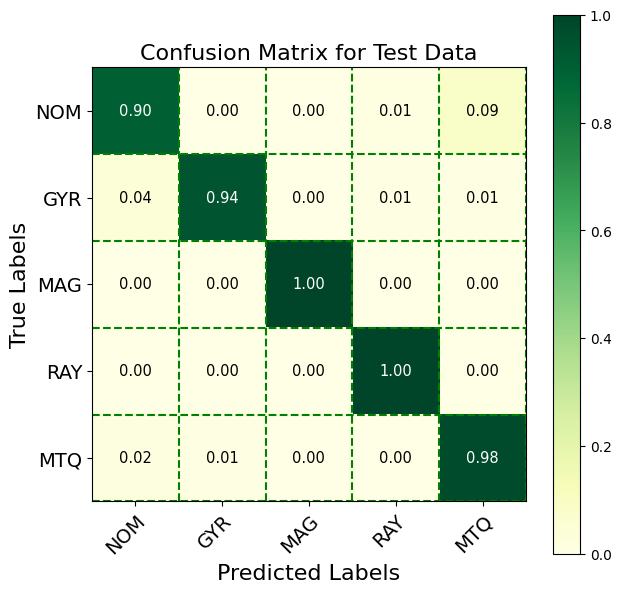

In [ ]:
CLASSES = [x for x in FAULT_DICT.values()]
true_class = [FAULT_DICT[x] for x in true_labels]
pred_class = [FAULT_DICT[x] for x in predicted_labels]

fig, ax = plot_confusion_matrix(true_labels,
                                predicted_labels,
                                fault_dict = FAULT_DICT,
                                normalize=True,
                                title="Confusion Matrix for Test Data",
                                fig_size=7)

## Draw time series

In [ ]:
# # file_name = '/content/drive/MyDrive/DL_result/{}/prediction/{}_{}_test1.npy'.format(SETTING_NAME,t,DATA_SOURCE)

# with open(file_name, 'rb') as f:
#   predictions_test = np.load(f)

# # TESTING SET
# with open('/content/drive/MyDrive/DL_setups/test1_labels.pkl', 'rb') as f:
#   labels = pickle.load(f)

CLASSES = [x for x in FAULT_DICT.values()]
true_class = [FAULT_DICT[x] for x in true_labels]
pred_class = [FAULT_DICT[x] for x in predicted_labels]

sample_steps = np.arange(predicted_labels.shape[0])

# precision_recall_fscore_support(y_true[:len(y_pred)], y_pred, average=None, labels=[0,2,3,4,5])
# precision_recall_fscore_support(y_true[:len(y_pred)], y_pred, average=None)
# precision_recall_fscore_support(y_true[:len(y_pred)], y_pred, average='weighted', labels=[0,2,3,4,5])
precision_recall_fscore_support(true_labels, predicted_labels, average='weighted')

(0.9633885828792909, 0.9626680922811202, 0.9626104337742595, None)

[11.  9.  8.  7.  6.]


<ipython-input-217-8ca424acee67>:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_yticklabels(yticks, fontsize=yticklabel_size)
<ipython-input-217-8ca424acee67>:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(xticks, fontsize=xticklabel_size)
<ipython-input-217-8ca424acee67>:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_yticklabels(yticks, fontsize=yticklabel_size)
<ipython-input-217-8ca424acee67>:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels(xticks, fontsize=xticklabel_size)


Text(0.5, 0, 'Sample Number')

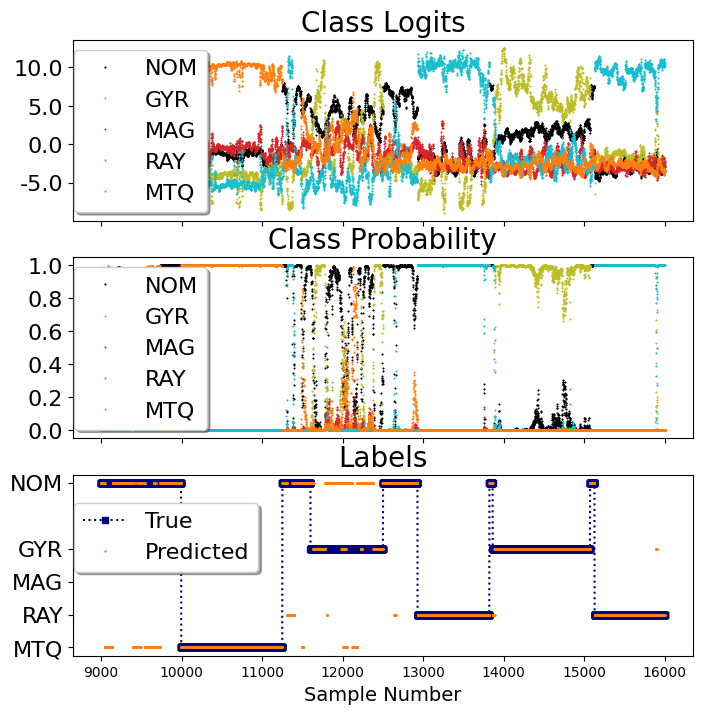

In [ ]:
fig, axs = plt.subplots(3, 1, sharex=True)
fig.set_size_inches(8,8)
start = 9000
end   = 16000
title_size = 20
ylabel_size = 20
xlabel_size = 14
yticklabel_size = 16
xticklabel_size = 12
legend_size = 16


color_list = ['black', 'royalblue', 'tab:olive', 'tab:red', 'tab:cyan',
              'tab:orange', 'tab:purple', 'tab:pink', 'tab:brown', 'tab:gray',
              'tan', 'aquamarine', 'coral']

# labels_for_legend = ['0:NOM','gyro freeze', '1:GYR', '2:MAG', '3:RAY', '4:MTQ']
for i in INCLUDE_CLASSES:
  axs[0].plot(sample_steps[start:end], predicted_logits[start:end,i], 's', markersize=0.5, color=color_list[i], label=FAULT_DICT[i])
# axs[0].legend(loc='upper left', shadow=True, prop={'size': legend_size})
axs[0].legend(bbox_to_anchor=(0., 0.95), loc='upper left',
           borderaxespad=0.05, shadow=True, prop={'size': legend_size})
# ax[0].legend(bbox_to_anchor=(0.68, 0.95), loc='upper left',
#            borderaxespad=0.05, shadow=True, prop={'size': legend_size})
axs[0].set_title('Class Logits',size=title_size)
yticks = np.round(axs[0].get_yticks(), 2)
axs[0].set_yticklabels(yticks, fontsize=yticklabel_size)
xticks = np.round(axs[0].get_xticks(), 0).astype(int)
axs[0].set_xticklabels(xticks, fontsize=xticklabel_size)


for i in INCLUDE_CLASSES:
  axs[1].plot(sample_steps[start:end], predicted_probabilities[start:end,i], 's', markersize=0.5, color=color_list[i], label=FAULT_DICT[i])
# axs[1].legend(loc='upper left', shadow=True, prop={'size': legend_size})
axs[1].legend(bbox_to_anchor=(0., 0.95), loc='upper left',
           borderaxespad=0.05, shadow=True, prop={'size': legend_size})
# ax[1].legend(bbox_to_anchor=(0.68, 0.95), loc='upper left',
#            borderaxespad=0.05, shadow=True, prop={'size': legend_size})
axs[1].set_title('Class Probability',size=title_size)
yticks = np.round(axs[1].get_yticks(), 2)
axs[1].set_yticklabels(yticks, fontsize=yticklabel_size)
xticks = np.round(axs[1].get_xticks(), 0).astype(int)
axs[1].set_xticklabels(xticks, fontsize=xticklabel_size)


np_pred_reverse = (NUM_CLASSES-1)*np.ones(len(pred_class)) - predicted_labels
np_true_reverse = (NUM_CLASSES-1)*np.ones(len(true_class)) - true_labels
axs[2].plot(sample_steps[start:end],np_true_reverse[start:end], ':s', markersize=5, color='navy', label='True')
axs[2].plot(sample_steps[start:end],np_pred_reverse[start:end], '.', markersize=1.5, color='tab:orange', label='Predicted')

axs[2].set_title('Labels',size=title_size)

# set_of_lables = set(np_true)
# ytcklbl = [FAULT_DICT[x] for x in set_of_lables]
# ytcklbl_reverse = ytcklbl[::-1]
# print(ytcklbl_reverse)
classes = (NUM_CLASSES-1)*np.ones(len(INCLUDE_CLASSES)) - INCLUDE_CLASSES
print(classes)
classes_reverse = classes[::-1]
ytcklbl_reverse = [FAULT_DICT[x] for x in set(true_labels)][::-1]
axs[2].set_yticks(classes_reverse)
axs[2].set_yticklabels(ytcklbl_reverse,size=yticklabel_size)
axs[2].legend(bbox_to_anchor=(0., 0.85), loc='upper left',
           borderaxespad=0.05, shadow=True, prop={'size': legend_size})
# axs[2].legend(bbox_to_anchor=(0.68, 0.85), loc='upper left',
#            borderaxespad=0.05, shadow=True, prop={'size': legend_size})

axs[2].set_xlabel('Sample Number',size=xlabel_size)

# fig.savefig('/content/drive/MyDrive/DL_result/{}/{}_{}_pred_probability.png'.format(SETTING_NAME,t,DATA_SOURCE), bbox_inches='tight', pad_inches=0.1, transparent=False)

## Setting up Neptune callback function for ML experiment tracking 👍
Check out [neptune.ai](https://neptune.ai/)

In [ ]:
# import neptune.new as neptune
# from neptune.new.integrations.tensorflow_keras import NeptuneCallback

# run = neptune.init(
#     project="",
#     api_token="",
# )  # your credentials

# run["parameters"] = params

# neptune_cbk = NeptuneCallback(run=run, base_namespace="training")

## Save tained model

In [ ]:
# run.stop() ## Neptune